# Train a HoVer-Net model from scratch with a pre-trained encoder

This example shows how to use `cellseg_models.pytorch` for training a [HoVer-Net](https://www.sciencedirect.com/science/article/abs/pii/S1361841519301045?via%3Dihub) model for instance segmentation with pytorch lightning along with the datasets and tools provided by the library. We will utilize [lightning](https://lightning.ai/docs/pytorch/latest/) to train the model.

In [1]:
# !pip install cellseg-models-pytorch

In [1]:
import torch
import lightning
import cellseg_models_pytorch
from platform import python_version

print("torch version:", torch.__version__)
print("lightning version:", lightning.__version__)
print("cellseg_models_pytorch version:", cellseg_models_pytorch.__version__)
print("python version:", python_version())

torch version: 2.1.1+cu121
lightning version: 2.3.1
cellseg_models_pytorch version: 0.1.25
python version: 3.10.12


## Download data

First, we will download some nuclei segmentation data. We will use the [Pannuke](https://jgamper.github.io/PanNukeDataset/) dataset by Gamper et al. The Pannuke dataset is split into three folds. We will use the first and second fold as training data and the third as validation data.

Since we will train the [HoVer-Net](https://www.sciencedirect.com/science/article/abs/pii/S1361841519301045?via%3Dihub) model, we need to define the right nuclei instance transformations for training time. For HoVer-Net, we define `"hovernet"` transformation. The `"hovernet"` transforms the labelled instance masks into horizontal and vertical image gradients of the nuclei. The model has an output head that regresses these types of masks which will be used for post-processing the nuclei.

Besides the instance mask transformations, we will also set `"blur"` and `"hue_sat"` (hue saturation) transformations and `"minmax"` normalization for the input images.

In [2]:
from pathlib import Path
from cellseg_models_pytorch.datamodules import PannukeDataModule

fold_split = {"fold1": "train", "fold2": "train", "fold3": "valid"}

# NOTE The 'pannuke' directory has to already exist for this to work.
# You can create one in your home folder or just modify the path to your liking,
# The pannuke dataset will be downloaded there.
save_dir = Path.home() / "pannuke_dataset"
pannuke_module = PannukeDataModule(
    save_dir=save_dir,
    fold_split=fold_split,
    inst_transforms=["hovernet"],
    img_transforms=["blur", "hue_sat"],
    normalization="minmax",
    batch_size=8,
    num_workers=8,
)

# NOTE: this will take a while to run
pannuke_module.prepare_data()  # download and process the pannuke data

Found all folds. Skip downloading.
Found processed pannuke data. If in need of a re-download, please empty the `save_dir` folder.


## Visualize training samples

Here we plot the training image patches with their corresponding instance and type label masks to get a glimpse of what kind of training data Pannuke has.

We also visualize the `hovernet` transformation applied to the instance masks. The `HoverNet`-model is going to regress this transformed auxilliary output which is later used in post-processing to separate overlapping and clumped nuclei.

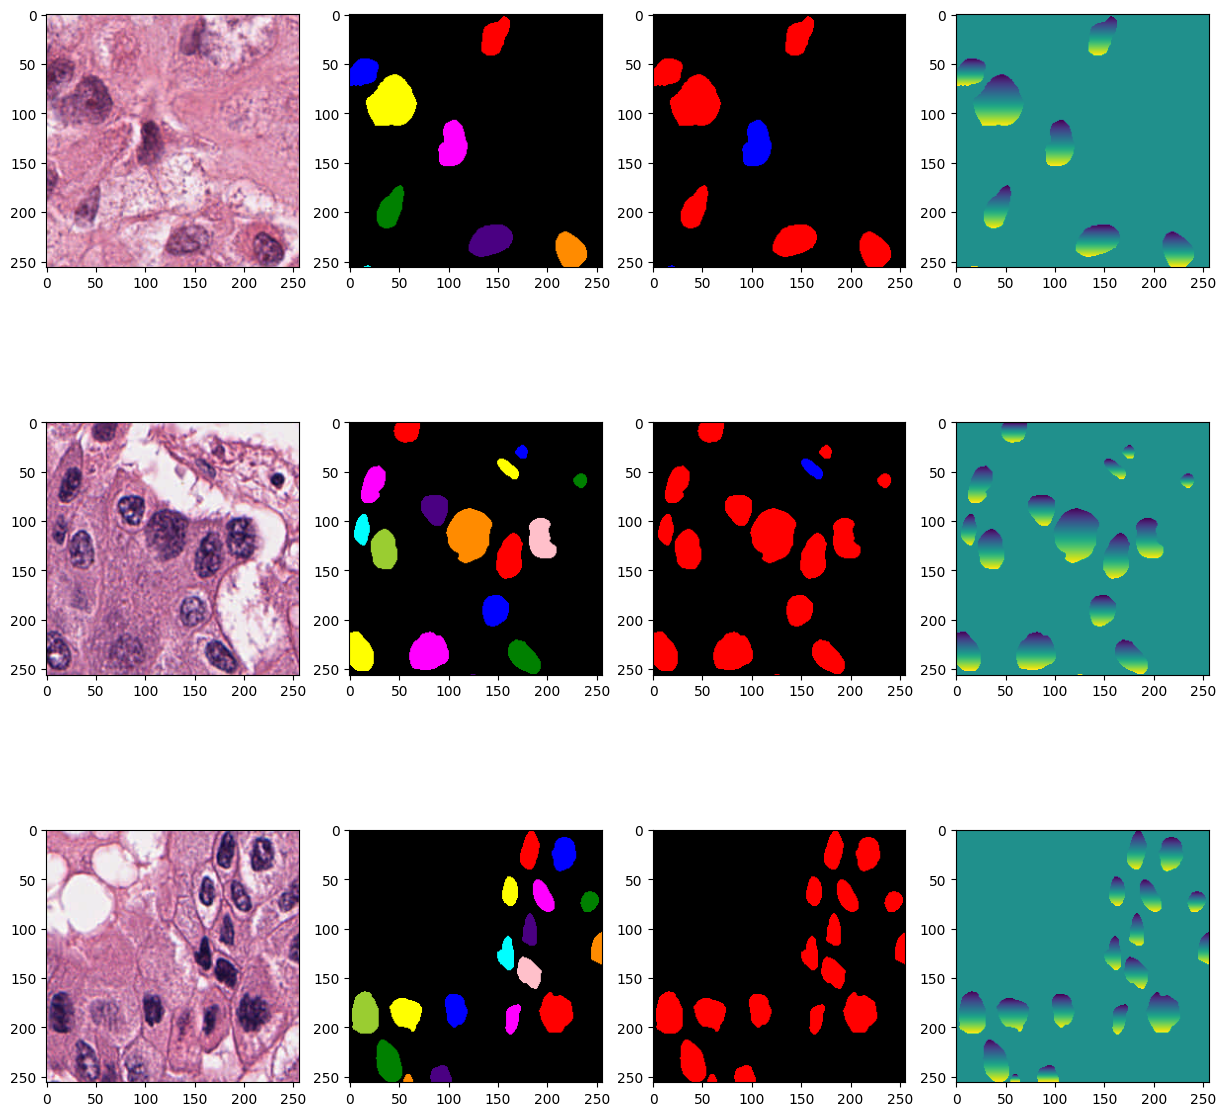

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb

# filehandler contains methods to read and write images and masks
from cellseg_models_pytorch.utils import FileHandler
from cellseg_models_pytorch.transforms.functional import gen_hv_maps

img_dir = save_dir / "train" / "images"
mask_dir = save_dir / "train" / "labels"
imgs = sorted(img_dir.glob("*"))
masks = sorted(mask_dir.glob("*"))

ixs = np.random.randint(0, 500, 3)

im1 = FileHandler.read_img(imgs[ixs[0]])
im2 = FileHandler.read_img(imgs[ixs[1]])
im3 = FileHandler.read_img(imgs[ixs[2]])
mask1 = FileHandler.read_mat(masks[ixs[0]], return_all=True)
mask2 = FileHandler.read_mat(masks[ixs[1]], return_all=True)
mask3 = FileHandler.read_mat(masks[ixs[2]], return_all=True)

fig, ax = plt.subplots(3, 4, figsize=(15, 15))
ax = ax.flatten()
ax[0].imshow(im1)
ax[1].imshow(label2rgb(mask1["inst_map"], bg_label=0))
ax[2].imshow(label2rgb(mask1["type_map"], bg_label=0))
ax[3].imshow(gen_hv_maps(mask1["inst_map"])[0])
ax[4].imshow(im2)
ax[5].imshow(label2rgb(mask2["inst_map"], bg_label=0))
ax[6].imshow(label2rgb(mask2["type_map"], bg_label=0))
ax[7].imshow(gen_hv_maps(mask2["inst_map"])[0])
ax[8].imshow(im3)
ax[9].imshow(label2rgb(mask3["inst_map"], bg_label=0))
ax[10].imshow(label2rgb(mask3["type_map"], bg_label=0))
ax[11].imshow(gen_hv_maps(mask3["inst_map"])[0])

## Building a LightningModule for training

Next, we will define a `SegmentationExperiment`. It is a `pl.LightningModule` wrapper that encapsulates everything needed for training the model. It is a nice way to wrap the model training logic behind a class abstraction. Check out the lightning docs for more: [`lightning`](https://lightning.ai/docs/pytorch/stable/common/trainer.html)

In the our `SegmentationExperiment`-class, we will have to take into account that the `PannukeDataModule`'s `DataLoader` returns the the inputs and targets in a dictionary like this:
```
{
    "image": torch.Tensor(B, 3, H, W),
    "inst": torch.Tensor(B, H, W),
    "type": torch.Tensor(B, C, H, W)
    "hovernet": torch.Tensor(B, aC, H, W)
}
```
We will access the `"image"` value in the `step()`-method to run the forward pass of the network.
The rest of the masks will be handled automatically in the multi-task-loss function.



In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import lightning.pytorch as pl
from typing import List, Tuple, Dict, Optional

from cellseg_models_pytorch.losses import MultiTaskLoss
from cellseg_models_pytorch.optimizers import adjust_optim_params


class SegmentationExperiment(pl.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        branch_losses: Dict[str, nn.Module],
        optimizer: optim.Optimizer,
        scheduler: optim.lr_scheduler._LRScheduler,
        optimizer_kwargs: Optional[Dict[str, float]] = None,
        scheduler_kwargs: Optional[Dict[str, float]] = None,
        **kwargs,
    ) -> None:
        """"""
        super().__init__()
        self.model = model
        self.heads = model.heads
        self.aux_key = model.aux_key
        self.inst_key = model.inst_key

        self.optimizer = optimizer
        self.scheduler = scheduler
        self.optimizer_kwargs = optimizer_kwargs or {}
        self.scheduler_kwargs = scheduler_kwargs or {}

        self.branch_losses = branch_losses

        self._validate_branch_args()
        self.save_hyperparameters(ignore="model")

        self.criterion = self.configure_loss()

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        """Forward pass."""
        return self.model(x)

    def step(
        self, batch: Dict[str, torch.Tensor]
    ) -> Tuple[torch.Tensor, Dict[str, torch.Tensor], Dict[str, torch.Tensor]]:
        """Compute the loss for one batch.

        Parameters
        ----------
            batch : Dict[str, torch.Tensor]
                The batch of data.
            batch_idx : int
                The batch index.

        Returns
        -------
            Tuple[torch.Tensor, Dict[str, torch.Tensor], Dict[str, torch.Tensor]]:
                The loss, the soft masks and the targets.
        """
        soft_masks = self.model(batch["image"])
        targets = {k: val for k, val in batch.items() if k != "image"}

        loss = self.criterion(yhats=soft_masks, targets=targets)

        return loss, soft_masks, targets

    def training_step(
        self, batch: Dict[str, torch.Tensor], batch_idx: int
    ) -> Dict[str, torch.Tensor]:
        """Training step."""
        # forward backward pass
        loss, _, _ = self.step(batch)

        # log the loss
        self.log("train_loss", loss, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    def validation_step(
        self, batch: Dict[str, torch.Tensor], batch_idx: int
    ) -> Dict[str, torch.Tensor]:
        """Validation step."""
        # forward pass
        loss, _, _ = self.step(batch)

        # log the loss
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=False)

        return loss

    def test_step(
        self, batch: Dict[str, torch.Tensor], batch_idx: int
    ) -> Dict[str, torch.Tensor]:
        """Test step."""
        # forward pass
        loss, _, _ = self.step(batch)

        # log the loss
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=False)

        return loss

    def configure_loss(self) -> nn.Module:
        """Configure the single/multi-task loss for the model."""
        # this loops through the losses and adds them to a dict
        # which is used as an input to the MultiTaskLoss class
        branch_losses = {}
        for branch, loss in self.branch_losses.items():
            branch_losses[branch] = loss

        return MultiTaskLoss(branch_losses=branch_losses)

    def configure_optimizers(self) -> List[optim.Optimizer]:
        """Configure the optimizers for the model."""
        params = {
            "encoder": {"lr": 0.00005, "weight_decay": 0.00005},
            "decoder": {"lr": 0.0005, "weight_decay": 0.0005},
        }
        optim_params = adjust_optim_params(self, params)
        opt = self.optimizer(optim_params)
        sch = self.scheduler(opt, **self.scheduler_kwargs)

        return {
            "optimizer": opt,
            "lr_scheduler": {
                "name": "train/lr",  # we can log the lr if needed
                "scheduler": sch,
                "monitor": "val_loss",
            },
        }

    def _validate_branch_args(self) -> None:
        """Check that there are no conflicting decoder branch args."""
        lk = set(self.branch_losses.keys())
        dk = set(self.model._get_inner_keys(self.model.heads))
        has_same_keys = lk == dk

        if not has_same_keys:
            raise ValueError(
                "Got mismatching keys for branch dict args. "
                f"Branch losses: {lk}. "
                f"Decoder branches: {dk}. "
                f"(`branch_metrics` can be None)"
            )

# Prepare the model and training setup

**The model**.
First, we will define the Hovernet nuclei segmentation model with a `imagenet` pre-trained encoder. Specifically, we will use the very basic `resnet50` backbone for this demonstration. Many more encoders can be used, since these are imported from the `timm` library. There are also support for some transformer based encoders, but these are shown in another notebooks.

**Branch losses**.
For each output of the model, we define a joint-loss function. These losses are summed together during backprop to form a multi-task loss. For the `"hovernet"`branch output we set a joint-loss composed of SSIM-loss (Structural Similarity Index) and MSE-loss (Mean Squared Error) and for the `"type"` (cell type predictions) and `"inst"` (cell background/foreground predictions) outputs we will set a joint-loss composed of CE-loss (Cross Entropy) and DICE-loss for both. For the CE-losses, we will also be using [spectral decoupling](https://arxiv.org/abs/2011.09468) and [label smoothing](https://arxiv.org/abs/1512.00567) to regularize the model. 

**Optimizer and scheduler.**
The optimizer used here is [AdamW](https://arxiv.org/abs/1711.05101). The learning rate is scheduled with the exponential schedule. The learning rate for the pre-trained encoder will be less (0.00005) than for the decoders (0.0005) that are initialized randomly since the encoder has already converged to some optimum. 

**Other hyperparams.**
We will train for 10 epochs (for demo purposes), so the training will probably not converge to the best possible result but anyways the model will learn something.

**NOTE** If torch >= 2.0 we can use the `torch.compile` to compile the model for better performance. Comment out if your pytorch version is less than 2.0 (Remember that the compiled models have bigger memory footprint htan non-compiled.). Also, we will train with 16bit precision to lower memory-footprint.

In [6]:
from cellseg_models_pytorch.losses import JointLoss, CELoss, DiceLoss, MSE
from cellseg_models_pytorch.models import hovernet_base

# initialize hovernet
model = hovernet_base(
    enc_name="resnet50", type_classes=len(pannuke_module.type_classes), inst_classes=2
)

# Define the loss-functions for each decoder branch.
branch_losses = {
    "inst": JointLoss([CELoss(apply_sd=True, apply_ls=True), DiceLoss()]),
    "type": JointLoss([CELoss(apply_sd=True, apply_ls=True), DiceLoss()]),
    "hovernet": JointLoss([MSE()]),
}


# Initialize the optimizer.
# We will be using the AdamW optimizer from the torch.optim library.
# First we adjust the learning rates and weight decay for each part of the network.
# Specifically, we will use a learning rate of 5e-5 for the encoder, 5e-4 for the
# decoders and output heads. We will also use a weight decay of 5e-5 for the encoder
# and 5e-4 for the decoders and output heads. The learning rate and weight decay is
# set to a smaller value for the encoder since it is pretrained on ImageNet.
adamw = optim.AdamW

# Initialize the learning rate scheduler. We will be usin the exponential LR scheduler
# with gamma=0.85
scheduler = optim.lr_scheduler.ExponentialLR

# Initialize the segmentation experiment lightning module.
experiment = SegmentationExperiment(
    model=model,
    branch_losses=branch_losses,
    optimizer=adamw,
    scheduler=scheduler,
    scheduler_kwargs={"gamma": 0.85},
)

# If torch >= 2.0 you can use this to compile the model for better performance
# experiment = torch.compile(experiment, mode="default")
# experiment

## Model training with lightning Trainer

In [8]:
# Set up model callbacks
callbacks = []

# we will add checkpointing to save the best model and the last model
ckpt_callback = pl.callbacks.ModelCheckpoint(
    dirpath=Path.home() / "pannuke" / "hovernet",
    save_top_k=1,
    save_last=True,
    verbose=True,
    monitor="val_loss",
    mode="min",
)
ckpt_callback.CHECKPOINT_NAME_LAST = "hovernet_last"
callbacks.append(ckpt_callback)

# Lightning training
trainer = pl.Trainer(
    accelerator="gpu",
    strategy="auto",  # let lightning decide how to distribute the training.
    precision="16-mixed",  # we'll use 16 bit precision to lower mem-footprint.
    max_epochs=10,
    devices=1,
    enable_progress_bar=True,
    callbacks=callbacks,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [10]:
# Train the model
trainer.fit(model=experiment, datamodule=pannuke_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found all folds. Skip downloading.
Found processed pannuke data. If in need of a re-download, please empty the `save_dir` folder.



  | Name      | Type          | Params | Mode 
----------------------------------------------------
0 | model     | HoverNet      | 41.1 M | train
1 | criterion | MultiTaskLoss | 0      | train
----------------------------------------------------
41.1 M    Trainable params
0         Non-trainable params
41.1 M    Total params
164.474   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 665: 'val_loss' reached 1.40966 (best 1.40966), saving model to '/home/leos/pannuke/hovernet/epoch=0-step=665.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 1313: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 1961: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 2609: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 3257: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 3905: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 4553: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 5201: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 5849: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 6497: 'val_loss' reached 1.18080 (best 1.18080), saving model to '/home/leos/pannuke/hovernet/epoch=9-step=6497.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


gg


# Model outputs

Next we will visualize what kind of outputs the model is able to produce after 5 epochs of training. 

Especially, we will look at the `hovernet`, `type` and the `inst` maps.

- The `inst` maps are used as the object (nuclei) masks that determine whether the model detects objects as nuclei or not.
- The `hovernet` maps on the other hand are used as the input for `hovernet`-post-processing pipeline that is used to separate clumped and overlapping nuclei from each other to produce an instance segmentation map. 
- The `type` maps are used to classify the nuclei instances into the `pannuke` cell type classes. Note that the type maps are also post-processed with a majority-voting approach in the post-processing pipeline since typically there is a mixture of different classes within a predicted nuclei as you will see from the type maps below. 

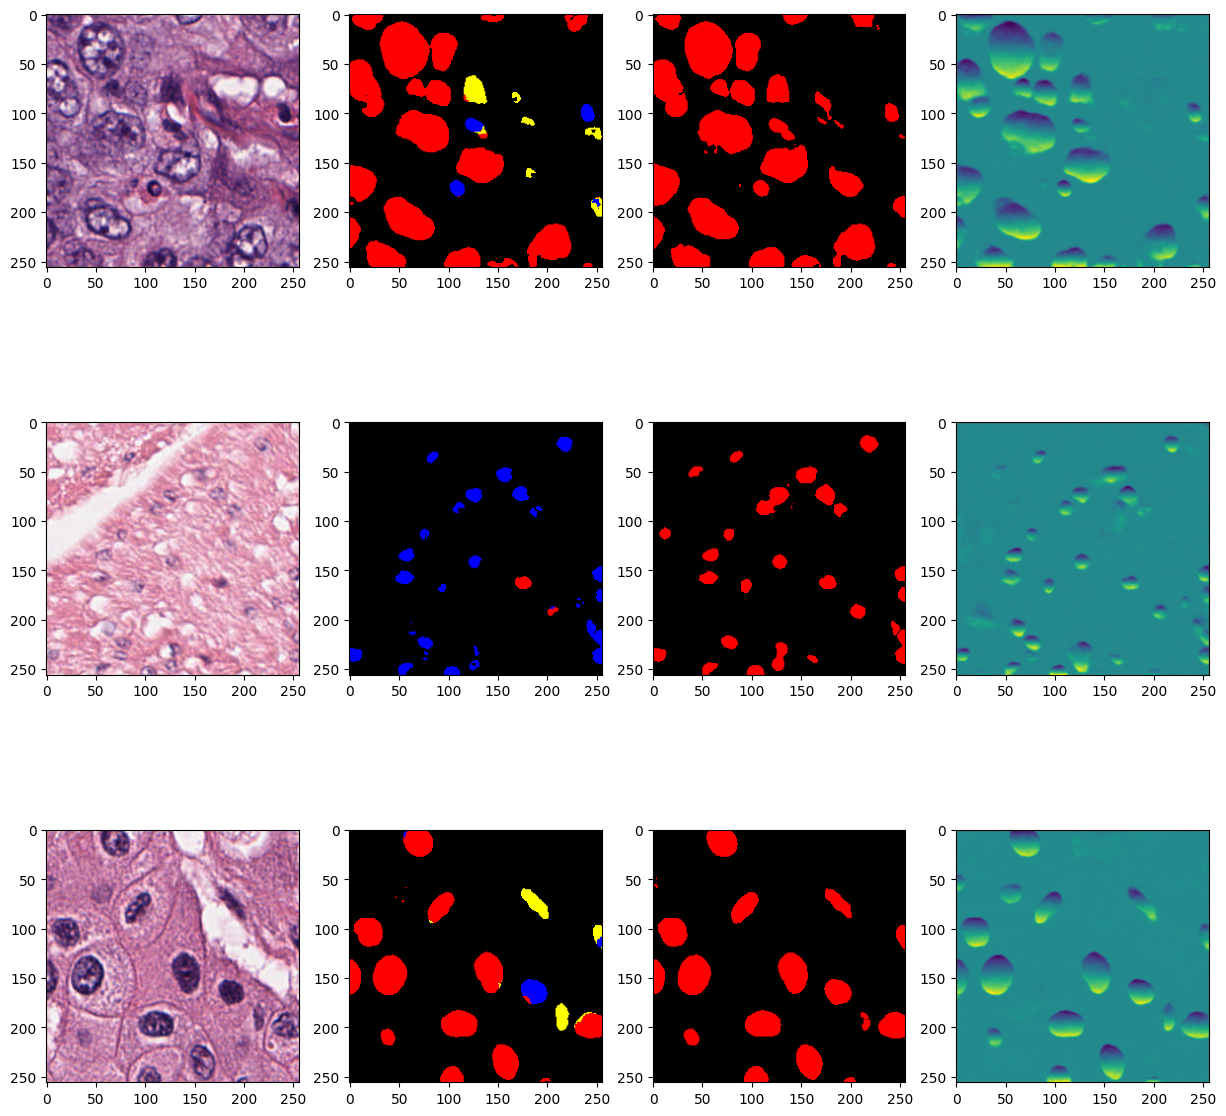

In [11]:
from cellseg_models_pytorch.utils import minmax_normalize

img_dir = save_dir / "valid" / "images"
mask_dir = save_dir / "valid" / "labels"
imgs = sorted(img_dir.glob("*"))
masks = sorted(mask_dir.glob("*"))

ixs = np.random.randint(0, 500, 3)
im1 = FileHandler.read_img(imgs[ixs[0]])
im2 = FileHandler.read_img(imgs[ixs[1]])
im3 = FileHandler.read_img(imgs[ixs[2]])
img1 = torch.from_numpy(minmax_normalize(im1)).permute(2, 0, 1).unsqueeze(0).float()
img2 = torch.from_numpy(minmax_normalize(im2)).permute(2, 0, 1).unsqueeze(0).float()
img3 = torch.from_numpy(minmax_normalize(im3)).permute(2, 0, 1).unsqueeze(0).float()

pred1 = experiment(img1)
pred2 = experiment(img2)
pred3 = experiment(img3)

fig, ax = plt.subplots(3, 4, figsize=(15, 15))
ax = ax.flatten()
ax[0].imshow(im1)
ax[1].imshow(
    label2rgb(np.argmax(pred1["type"].squeeze().detach().numpy(), axis=0), bg_label=0)
)
ax[2].imshow(
    label2rgb(np.argmax(pred1["inst"].squeeze().detach().numpy(), axis=0), bg_label=0)
)
ax[3].imshow(pred1["hovernet"].squeeze().detach().numpy()[0])
ax[4].imshow(im2)
ax[5].imshow(
    label2rgb(np.argmax(pred2["type"].squeeze().detach().numpy(), axis=0), bg_label=0)
)
ax[6].imshow(
    label2rgb(np.argmax(pred2["inst"].squeeze().detach().numpy(), axis=0), bg_label=0)
)
ax[7].imshow(pred2["hovernet"].squeeze().detach().numpy()[0])
ax[8].imshow(im3)
ax[9].imshow(
    label2rgb(np.argmax(pred3["type"].squeeze().detach().numpy(), axis=0), bg_label=0)
)
ax[10].imshow(
    label2rgb(np.argmax(pred3["inst"].squeeze().detach().numpy(), axis=0), bg_label=0)
)
ax[11].imshow(pred3["hovernet"].squeeze().detach().numpy()[0])

## Inference and post-processing

Typically, encoder-decoder based nuclei segmentation model outputs require post-processing. The main-task of the post-processing is to separate clumped nuclear-objects which is a renowned problem in nuclei segmentation. With `cellseg_models.pytorch`, inference and post-processing can be executed with specific `Inferer` classes that can be found in the `cellseg_models_pytorch.inference` module. 

Since the Pannuke-dataset has only 256x256px images, we can use the `ResizeInferer` to run the inference and post-processing (without actually resizing the images). The `Inferer`s take in an input directory and a set of arguments, from which, the `instance_postproc` is the most important since it sets the post-processing method to be used. Here, naturally, we will use `hovernet` post-processing since we're running inference for a Hover-Net model.

Other important params include: 
- `out_activations` - Sets the output activation functions for each of the model outputs
- `out_boundary_weights` - Sets whether we will use a weight matrix to add less weight to boundaries of the predictions. This can only be useful when inference is run for bigger images that are patched in overlapping patches (inference with overlapping patches can be done with the `SlidingWindowInferer`).
- `normalization` - Should be set to the same one as during training.
- `n_images` - Run inference only for the 50 first images of inside the input folder.

In [13]:
from cellseg_models_pytorch.inference import ResizeInferer

inferer = ResizeInferer(
    model=experiment,
    input_path=save_dir / "valid" / "images",
    out_activations={"hovernet": None, "inst": "sigmoid", "type": "softmax"},
    out_boundary_weights={"hovernet": False, "inst": False, "type": False},
    resize=(256, 256),  # Not actually resizing anything,
    instance_postproc="hovernet",
    batch_size=8,
    n_images=50,  # Use only the 50 first images of the folder
    normalization="minmax",
    checkpoint_path=trainer.checkpoint_callback.best_model_path,
)
inferer.infer()

Running inference: 100%|██████████| 7/7 [00:01<00:00,  5.61batch/s, post-processing]


**Let's plot some results**

With only 5 epochs of training, we can get moderate results by just eyeballing. 

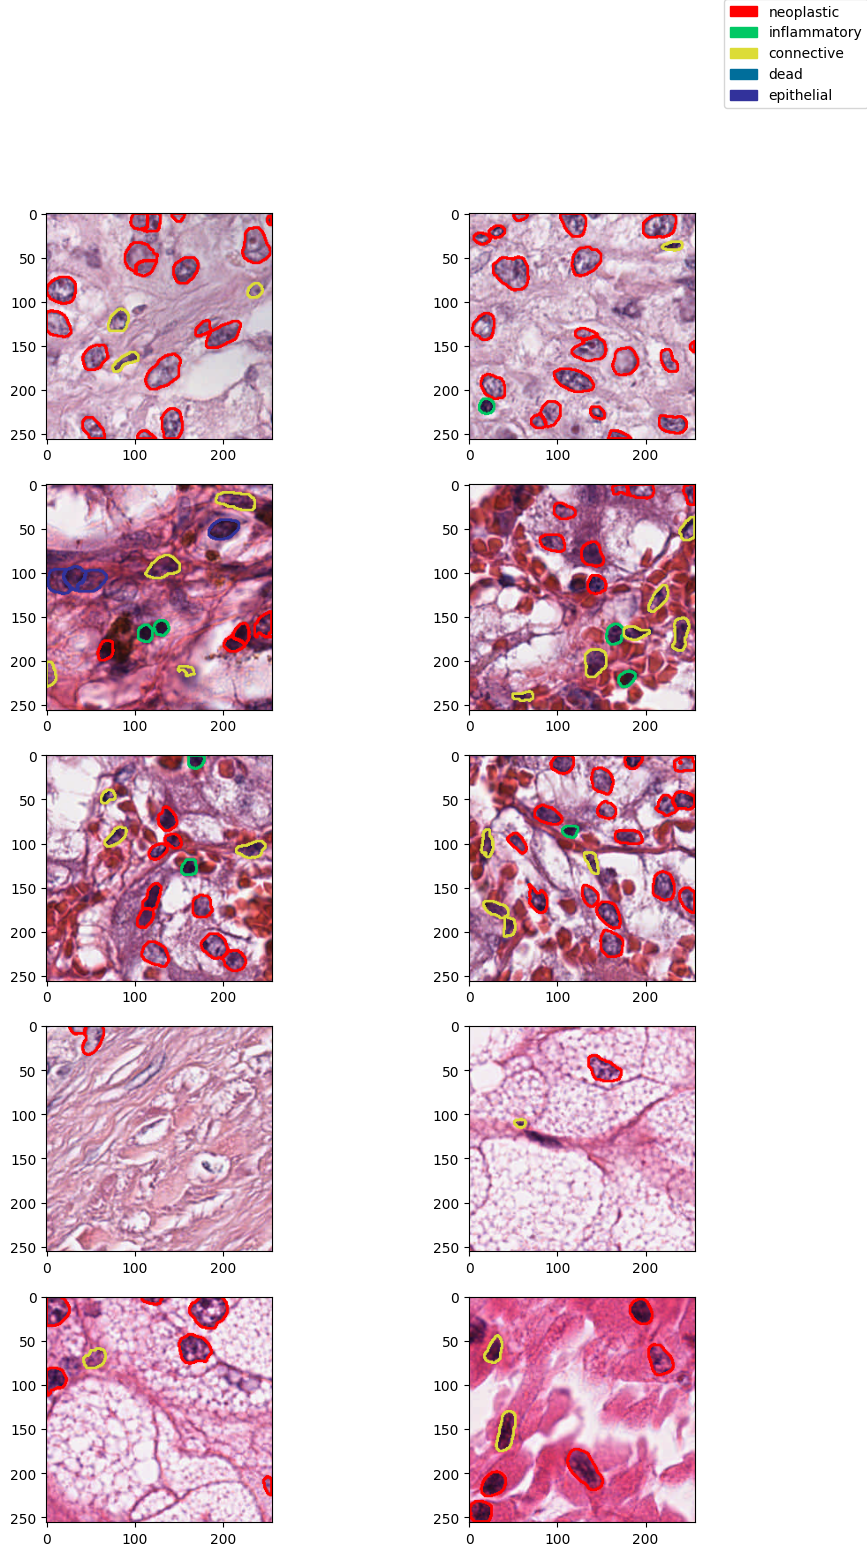

In [14]:
import numpy as np
from cellseg_models_pytorch.utils import draw_thing_contours
import matplotlib.patches as mpatches


fig, ax = plt.subplots(5, 2, figsize=(10, 17))
ax = ax.flatten()
ixs = np.random.choice(50, 10, replace=False)

samples = list(inferer.out_masks.keys())
for i, ix in enumerate(ixs):
    masks = inferer.out_masks[samples[ix]]

    img_path = save_dir / "valid" / f"images/{samples[ix]}.png"
    img = FileHandler.read_img(img_path)
    cont = draw_thing_contours(masks["inst"], img, masks["type"])
    ax[i].imshow(cont)

# add legend
cmap = {
    1: (255.0 / 255, 0.0, 0.0),
    2: (0.0, 200.0 / 255, 100.0 / 255),
    3: (220.0 / 255, 220.0 / 255, 55.0 / 255),
    4: (0.0, 110.0 / 255, 155.0 / 255),
    5: (50.0 / 255, 50.0 / 255, 155.0 / 255),
}
labels = {k: j for j, k in pannuke_module.type_classes.items()}
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
fig.legend(handles=patches, loc=1, borderaxespad=0)